# Results
This notebook aggregates the data in the `metrics.jsonl` and `eval_metrics.csv` files in the `results` directory and produces tables for analysis.

## Import, helpers

In [2]:
import os
import json
import glob
import pandas as pd
import numpy as np
import yaml
import re
import math

In [3]:
def get_run_name(csv_path):
    # Use the grandparent, parent, and base name as the run name
    base = os.path.basename(csv_path)
    parent = os.path.basename(os.path.dirname(csv_path))
    grandparent = os.path.basename(os.path.dirname(os.path.dirname(csv_path)))
    great_grandparent = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(csv_path))))
    return os.path.join(great_grandparent, grandparent, parent)

### Load configuration files

In [4]:
# find all the config.yaml files in results subdirs
# add each one to a df with the run_id as a column
RESULTS_DIR = "../results/"
def find_configs(results_dir):
    config_paths = glob.glob(os.path.join(results_dir, "**/config.yaml"), recursive=True)
    return config_paths

def load_and_combine(config_paths):
    dfs = []
    for path in config_paths:
        # run_id = path.removeprefix('../').removesuffix('/config.yaml')
        run_id = get_run_name(path)

        with open(path, 'r') as f:

            yaml_text = f.read()
            # hack because i was silly and saved devices in the yaml
            yaml_text = re.sub(
                r'device:\s*!!python/object/apply:torch\.device\s*\n\s*-\s*(\w+)',
                r'device: "\1"',
                yaml_text
            )

            config = yaml.safe_load(yaml_text) or {}
            
        config_flat = pd.json_normalize(config)
        config_flat['run_id'] = run_id
        dfs.append(config_flat)
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame()  # Empty DataFrame if nothing found
    
configs_df = load_and_combine(find_configs(RESULTS_DIR))
print(f"Loaded {len(configs_df)} runs, combined shape: {configs_df.shape}")

Loaded 100 runs, combined shape: (100, 72)


In [5]:
configs_df['run_id']

0           results/ch4_scaffolding/80_ant_dots_cont
1     results/ch4_scaffolding/64_circuit_coords_disc
2           results/ch4_scaffolding/32_xor_dots_disc
3           results/ch4_scaffolding/40_ant_dots_disc
4       results/ch4_scaffolding/32_noise_coords_disc
                           ...                      
95    results/2025-10-25/192707_40_sparkle_none_cont
96    results/2025-10-25/190141_40_sparkle_none_cont
97    results/2025-10-25/191026_40_sparkle_none_cont
98    results/2025-10-25/185922_40_sparkle_none_cont
99    results/2025-10-25/192942_40_sparkle_none_cont
Name: run_id, Length: 100, dtype: object

### Load evaluation metrics
The `evaluate_checkpoints.py` script must be run first to measure the performance of the trained models. This section loads the `eval_metrics.csv` files produced by that script.

In [6]:
RESULTS_DIR = "../results"
CSV_NAME = "eval_runs_summary.csv"

def find_eval_csvs(results_dir):
    # Recursively find all eval_runs_summary.csv files
    pattern = os.path.join(results_dir, "**", CSV_NAME)
    return glob.glob(pattern, recursive=True)

def load_and_combine(csv_paths):
    dfs = []
    for csv_path in csv_paths:
        try:
            df = pd.read_csv(csv_path)
            df["run_id"] = get_run_name(csv_path)
            dfs.append(df)
        except Exception as e:
            print(f"Failed to load {csv_path}: {e}")
    if dfs:
        combined = pd.concat(dfs, ignore_index=True)
        return combined
    else:
        return pd.DataFrame()  # Empty DataFrame if nothing found

csv_paths = find_eval_csvs(RESULTS_DIR)
evals_df = load_and_combine(csv_paths)
print(f"Loaded {len(csv_paths)} runs, combined shape: {evals_df.shape}")

Loaded 86 runs, combined shape: (8600, 17)


In [7]:
evals_df.columns

Index(['run', 'max_mse', 'max_acc', 'max_acc_snap', 'mean_mse_window',
       'mean_acc_window', 'mean_acc_snap_window', 'mean_mse_tail',
       'mean_acc_tail', 'mean_acc_snap_tail', 'reached_acc_1',
       'step_reached_acc_1', 'maintained_acc_after_reach',
       'reached_acc_snap_1', 'step_reached_acc_snap_1',
       'maintained_acc_snap_after_reach', 'run_id'],
      dtype='object')

In [8]:
eval_summ = evals_df.sort_values('run_id', ascending=False)

#### Reconcile config and evaluation dfs

In [9]:
# missing from config
set(eval_summ["run_id"]) - set(configs_df["run_id"])

set()

In [10]:
# missing from eval (probably haven't run eval since the first date)
set(configs_df["run_id"]) - set(eval_summ["run_id"])

{'results/2025-10-25/175250_40_sparkle_none_cont',
 'results/2025-10-25/185922_40_sparkle_none_cont',
 'results/2025-10-25/190141_40_sparkle_none_cont',
 'results/2025-10-25/191026_40_sparkle_none_cont',
 'results/2025-10-25/192707_40_sparkle_none_cont',
 'results/2025-10-25/192942_40_sparkle_none_cont',
 'results/2025-10-25/193046_40_sparkle_none_cont',
 'results/2025-10-25/193119_40_sparkle_none_cont',
 'results/2025-10-25/213018_40_speckle_dots_cont',
 'results/2025-10-25/231045_40_speckle_dots_cont',
 'results/2025-10-26/110458_80_me_dots_cont',
 'results/2025-10-26/124013_80_me_dots_cont',
 'results/2025-10-26/grey-face',
 'results/2025-10-29/094546_80_me_dots_cont'}

#### Final evaluation metrics df

In [11]:
# join the config and eval df on run_id
eval_summ = eval_summ.merge(configs_df, on="run_id", how="left").sort_values('run_id').reset_index(drop=True)

In [12]:
print(f"Eval summary shape: {eval_summ.shape}")

Eval summary shape: (8600, 88)


# Analysis

In [13]:
# let's check that we have all the runs, and no duplicates or anything weird.

# group by target.target_image, model.landmarks.type, training.mode, rollout.min, rollout.max, num_to_damage, pool_size
eval_counts = eval_summ.groupby([
    "target.target_image", "target.target_size",
    "model.landmarks.type", "training.mode",
    "training.rollout.min", "training.rollout.max",
    "training.num_to_damage", "training.pool_size"
]).agg(
    count=("run_id", "count"),
).reset_index()
eval_counts


,target.target_image,target.target_size,model.landmarks.type,training.mode,training.rollout.min,training.rollout.max,training.num_to_damage,training.pool_size,count
0,data/targets/test/noise-24.png,24,none,continuous,64,96,0,1024,100
1,data/targets/test/noise-24.png,24,none,discrete,64,96,0,1024,100
2,data/targets/wireworld/golly-and-multiple-48.png,48,coordinate,continuous,64,96,0,1024,100
3,data/targets/wireworld/golly-and-multiple-48.png,48,coordinate,discrete,64,96,0,1024,100
4,data/targets/wireworld/golly-and-multiple-48.png,48,dots,continuous,64,96,0,1024,100
...,...,...,...,...,...,...,...,...,...
81,data/targets/wireworld/noise-32.png,32,coordinate,discrete,64,96,0,1024,100
82,data/targets/wireworld/noise-32.png,32,dots,continuous,64,96,0,1024,100
83,data/targets/wireworld/noise-32.png,32,dots,discrete,64,96,0,1024,100
84,data/targets/wireworld/noise-32.png,32,none,continuous,64,96,0,1024,100


In [14]:
eval_summ.columns

Index(['run', 'max_mse', 'max_acc', 'max_acc_snap', 'mean_mse_window',
       'mean_acc_window', 'mean_acc_snap_window', 'mean_mse_tail',
       'mean_acc_tail', 'mean_acc_snap_tail', 'reached_acc_1',
       'step_reached_acc_1', 'maintained_acc_after_reach',
       'reached_acc_snap_1', 'step_reached_acc_snap_1',
       'maintained_acc_snap_after_reach', 'run_id', 'compute.device',
       'compute.mixed_precision', 'compute.num_threads',
       'compute.requested_device', 'experiment.comment', 'experiment.name',
       'experiment.seed', 'experiment.version_used', 'misc.debug',
       'misc.preview_target_image', 'model.alive_threshold', 'model.fire_rate',
       'model.landmarks.params.spacing', 'model.landmarks.params.value',
       'model.landmarks.type', 'model.num_channels', 'model.num_hidden',
       'model.num_visible', 'model.seed_alpha', 'model.step_size',
       'results.batch_images.enabled', 'results.batch_images.interval',
       'results.ca_rollout.ca_steps', 'results.ca

In [15]:
# replace the True and False with 1 and 0
for column in ['reached_acc_1', 'maintained_acc_after_reach', 'reached_acc_snap_1', 'maintained_acc_snap_after_reach']:
    eval_summ[column] = eval_summ[column].astype(int)

In [16]:
gp = eval_summ.groupby([
    "target.target_size", "target.target_image", "training.mode", "training.num_to_damage",
    "training.pool_size", "training.rollout.min", "training.rollout.max", "model.landmarks.type"
]).agg(
    # means + variances for primary metrics
    max_mse_mean=("max_mse", "mean"),
    max_mse_var=("max_mse", "var"),

    max_acc_mean=("max_acc", "mean"),
    max_acc_var=("max_acc", "var"),

    max_acc_snap_mean=("max_acc_snap", "mean"),
    max_acc_snap_var=("max_acc_snap", "var"),

    mean_mse_window_mean=("mean_mse_window", "mean"),
    mean_mse_window_var=("mean_mse_window", "var"),

    mean_acc_window_mean=("mean_acc_window", "mean"),
    mean_acc_window_var=("mean_acc_window", "var"),

    mean_acc_snap_window_mean=("mean_acc_snap_window", "mean"),
    mean_acc_snap_window_var=("mean_acc_snap_window", "var"),

    mean_mse_tail_mean=("mean_mse_tail", "mean"),
    mean_mse_tail_var=("mean_mse_tail", "var"),

    mean_acc_tail_mean=("mean_acc_tail", "mean"),
    mean_acc_tail_var=("mean_acc_tail", "var"),

    mean_acc_snap_tail_mean=("mean_acc_snap_tail", "mean"),
    mean_acc_snap_tail_var=("mean_acc_snap_tail", "var"),

    # counts and step stats for reaching perfect snapped accuracy
    count_reached_acc_snap_1=("reached_acc_snap_1", "sum"),
    mean_step_reached_acc_snap_1=("step_reached_acc_snap_1", "mean"),
    var_step_reached_acc_snap_1=("step_reached_acc_snap_1", "var"),
    count_maintained_acc_snap_after_reach=("maintained_acc_snap_after_reach", "sum"),

    # counts and steps stats for reaching perfect (non-snapped) accuracy
    count_reached_acc_1=("reached_acc_1", "sum"),
    mean_step_reached_acc_1=("step_reached_acc_1", "mean"),
    var_step_reached_acc_1=("step_reached_acc_1", "var"),
    count_maintained_acc_after_reach=("maintained_acc_after_reach", "sum"),

    # run count
    count=("run_id", "count"),
).reset_index()

gp
# ...existing code...

,target.target_size,target.target_image,training.mode,training.num_to_damage,training.pool_size,training.rollout.min,training.rollout.max,model.landmarks.type,max_mse_mean,max_mse_var,...,mean_acc_snap_tail_var,count_reached_acc_snap_1,mean_step_reached_acc_snap_1,var_step_reached_acc_snap_1,count_maintained_acc_snap_after_reach,count_reached_acc_1,mean_step_reached_acc_1,var_step_reached_acc_1,count_maintained_acc_after_reach,count
0,16,data/targets/wireworld/golly-langtons-ant-crop...,continuous,0,1024,64,96,coordinate,0.044192,4.899111e-08,...,0.000170,16,53.187500,6.562500,16,0,NaN,NaN,0,100
1,16,data/targets/wireworld/golly-langtons-ant-crop...,continuous,0,1024,64,96,dots,0.044142,2.840284e-08,...,0.000165,11,55.545455,24.272727,11,0,NaN,NaN,0,100
2,16,data/targets/wireworld/golly-langtons-ant-crop...,continuous,0,1024,64,96,none,0.044123,2.870745e-08,...,0.000452,10,60.400000,268.044444,10,0,NaN,NaN,0,100
3,16,data/targets/wireworld/golly-langtons-ant-crop...,discrete,0,1024,64,96,coordinate,0.044366,1.255122e-08,...,0.000546,13,58.076923,20.743590,10,13,60.153846,39.141026,10,100
4,16,data/targets/wireworld/golly-langtons-ant-crop...,discrete,0,1024,64,96,dots,0.044271,6.651018e-09,...,0.000706,19,61.526316,39.152047,17,19,62.631579,39.578947,18,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,80,data/targets/wireworld/golly-langtons-ant-80.png,continuous,0,1024,64,96,dots,0.194090,2.810847e-06,...,0.004669,0,NaN,NaN,0,0,NaN,NaN,0,100
82,80,data/targets/wireworld/golly-langtons-ant-80.png,continuous,0,1024,64,96,none,0.193728,4.565221e-10,...,0.002017,0,NaN,NaN,0,0,NaN,NaN,0,100
83,80,data/targets/wireworld/golly-langtons-ant-80.png,discrete,0,1024,64,96,coordinate,0.193692,3.844316e-10,...,0.000005,0,NaN,NaN,0,0,NaN,NaN,0,100
84,80,data/targets/wireworld/golly-langtons-ant-80.png,discrete,0,1024,64,96,dots,0.193711,3.362640e-10,...,0.000016,0,NaN,NaN,0,0,NaN,NaN,0,100


In [17]:
set(gp['target.target_image'])

{'data/targets/test/noise-24.png',
 'data/targets/wireworld/golly-and-multiple-48.png',
 'data/targets/wireworld/golly-and-single-32.png',
 'data/targets/wireworld/golly-circuit-64.png',
 'data/targets/wireworld/golly-clocks-48.png',
 'data/targets/wireworld/golly-flip-flop-32.png',
 'data/targets/wireworld/golly-langtons-ant-40.png',
 'data/targets/wireworld/golly-langtons-ant-80.png',
 'data/targets/wireworld/golly-langtons-ant-crop-16.png',
 'data/targets/wireworld/golly-langtons-ant-crop-24.png',
 'data/targets/wireworld/golly-memory-cell-48.png',
 'data/targets/wireworld/golly-or-32.png',
 'data/targets/wireworld/golly-unary-multiplier-crop-40.png',
 'data/targets/wireworld/golly-xor-32.png',
 'data/targets/wireworld/noise-32.png'}

In [18]:
# filter out any rows with landmarks.type != 'none'
gp = gp[gp['model.landmarks.type'] == 'none']
# filter out rows with num_to_damage > 0
gp = gp[gp['training.num_to_damage'] == 0]
# filter out rows with pool_size != 1024
gp = gp[gp['training.pool_size'] == 1024]

# create barplot that shows four columns for each target image: mean_acc_window (discrete), mean_acc_window (continuous), mean_acc_snap_window (discrete) and mean_acc_snap_window (continuous)
# don't use melt

import matplotlib.pyplot as plt
import numpy as np
import os

# Map full target paths to short names (fill in as needed)
short_name_map = {
    # 'data/targets/test/noise-24.png': 'Noise 24',
    'data/targets/wireworld/golly-and-multiple-48.png': 'AND (mult.) 48',
    'data/targets/wireworld/golly-and-single-32.png': 'AND 32',
    'data/targets/wireworld/golly-clocks-48.png': 'Clocks 48',
    'data/targets/wireworld/golly-flip-flop-32.png': 'Flip-flop 32',
    'data/targets/wireworld/golly-langtons-ant-40.png': 'Ant 40',
    'data/targets/wireworld/golly-langtons-ant-80.png'  : 'Ant 80',
    'data/targets/wireworld/golly-langtons-ant-crop-16.png': 'Ant (crop) 16',
    'data/targets/wireworld/golly-langtons-ant-crop-24.png': 'Ant (crop) 24',
    'data/targets/wireworld/golly-memory-cell-48.png'   : 'Memory 48',
    'data/targets/wireworld/golly-or-32.png'      : 'OR 32',
    'data/targets/wireworld/golly-unary-multiplier-crop-40.png': 'Unary (crop) 40',
    'data/targets/wireworld/golly-xor-32.png'     : 'XOR 32',
    'data/targets/wireworld/golly-circuit-64.png': 'Circuit 64',
    'data/targets/wireworld/noise-32.png': 'Noise 32',
}

df_diff = gp.assign(
    diff=lambda d: d["mean_acc_snap_window"] - d["mean_acc_window"]
)
df_diff = df_diff.sort_values("target.target_size")
df_diff['target.target_image'] = df_diff['target.target_image'].map(short_name_map)
sns.set_context("notebook", rc={"axes.linewidth": 0.5, "grid.linewidth": 0.5})
plt.figure(figsize=(max(11, len(df_diff['target.target_image'].unique()) * 0.6), 5))
sns.barplot(x="target.target_image", y="diff", hue="training.mode", data=df_diff, errorbar=None, linewidth=0.5, edgecolor=".2")
plt.ylabel("Δ Mean Accuracy (snap - normal)")
plt.xlabel("Target Pattern")
plt.legend(title="Training Mode")
plt.title("Effect of Snapping on Accuracy by Training Mode")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Prepare dataframe with short names
gp_plot_df = gp.copy()
gp_plot_df['short_name'] = gp_plot_df['target.target_image'].map(short_name_map)
gp_plot_df['short_name'] = gp_plot_df['short_name'].fillna(
    gp_plot_df['target.target_image'].apply(lambda p: os.path.splitext(os.path.basename(str(p)))[0])
)

# Aggregate mean per short_name and mode
group = gp_plot_df.groupby(['short_name', 'training.mode']).agg({
    'mean_acc_window': 'mean',
    'mean_acc_snap_window': 'mean'
}).reset_index()

short_names = sorted(group['short_name'].unique())
modes = sorted(group['training.mode'].unique())

# Build plotting frame: columns for each metric+mode combination
plot_df = pd.DataFrame(index=short_names)
metrics = ['mean_acc_window', 'mean_acc_snap_window']
for metric in metrics:
    for mode in modes:
        col = f"{metric}_{mode}"
        series = group.loc[group['training.mode'] == mode].set_index('short_name')[metric]
        plot_df[col] = series.reindex(short_names).values

# Plot grouped bars (robust, no seaborn 'position' kw)
n_cols = plot_df.shape[1]
bar_width = 0.18
x = np.arange(len(short_names))
# center the groups
start = - (n_cols - 1) / 2 * bar_width
offsets = [start + i * bar_width for i in range(n_cols)]

plt.figure(figsize=(max(8, len(short_names) * 0.6), 6))
for i, col in enumerate(plot_df.columns):
    plt.bar(x + offsets[i], plot_df[col].values, width=bar_width, label=col.replace('_', ' '))

plt.xticks(x, short_names, rotation=45, ha='right')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy and Snap Accuracy by Target Image and Training Mode')
plt.legend(title='Metric (mode)', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

KeyError: 'mean_acc_snap_window'

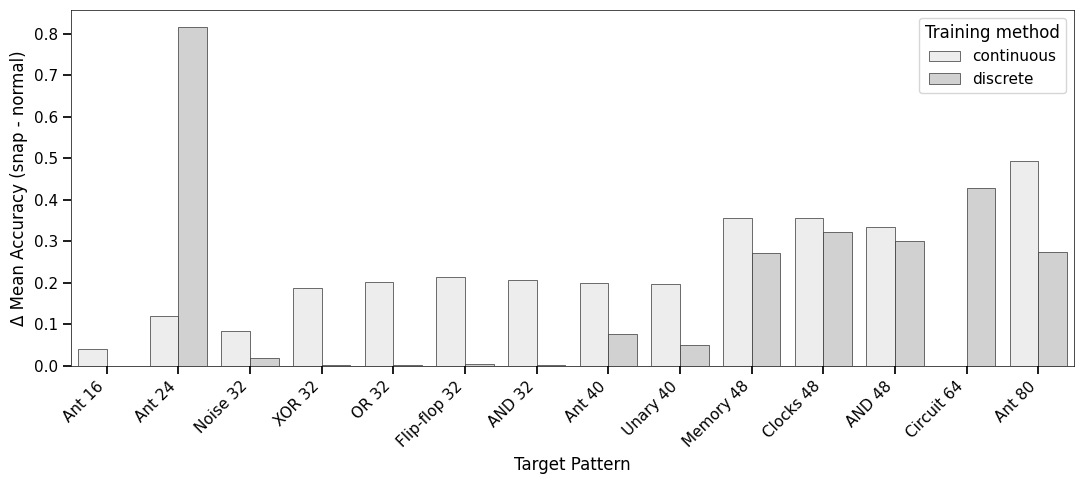

In [21]:
import seaborn as sns
sns.set_palette("Greys")

short_name_map = {
    # 'data/targets/test/noise-24.png': 'Noise 24',
    'data/targets/wireworld/golly-and-multiple-48.png': 'AND 48',
    'data/targets/wireworld/golly-and-single-32.png': 'AND 32',
    'data/targets/wireworld/golly-clocks-48.png': 'Clocks 48',
    'data/targets/wireworld/golly-flip-flop-32.png': 'Flip-flop 32',
    'data/targets/wireworld/golly-langtons-ant-40.png': 'Ant 40',
    'data/targets/wireworld/golly-langtons-ant-80.png'  : 'Ant 80',
    'data/targets/wireworld/golly-langtons-ant-crop-16.png': 'Ant 16',
    'data/targets/wireworld/golly-langtons-ant-crop-24.png': 'Ant 24',
    'data/targets/wireworld/golly-memory-cell-48.png'   : 'Memory 48',
    'data/targets/wireworld/golly-or-32.png'      : 'OR 32',
    'data/targets/wireworld/golly-unary-multiplier-crop-40.png': 'Unary 40',
    'data/targets/wireworld/golly-xor-32.png'     : 'XOR 32',
    'data/targets/wireworld/golly-circuit-64.png': 'Circuit 64',
    'data/targets/wireworld/noise-32.png': 'Noise 32',
}

df_diff = gp.assign(
    diff=lambda d: d["mean_acc_snap_window_mean"] - d["mean_acc_window_mean"]
)
df_diff = df_diff.sort_values("target.target_size")
df_diff['target.target_image'] = df_diff['target.target_image'].map(short_name_map)
sns.set_context("notebook", rc={"axes.linewidth": 0.5, "grid.linewidth": 0.5})
plt.figure(figsize=(max(11, len(df_diff['target.target_image'].unique()) * 0.6), 5))
sns.barplot(x="target.target_image", y="diff", hue="training.mode", data=df_diff, errorbar=None, linewidth=0.5, edgecolor=".2")
plt.ylabel("Δ Mean Accuracy (snap - normal)")
plt.xlabel("Target Pattern")
plt.legend(title="Training method")
# plt.title("Effect of Snapping on Accuracy by Training Method")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [121]:
# create a pivot that shows how many rows for each
# first filter out any with num_to_damage > 0 OR pool_size != 1024
# then group by target_image, training mode, and landmarks.type
eval_drop = eval_summ[
    (eval_summ['training.num_to_damage'] == 0) &
    (eval_summ['training.pool_size'] == 1024)]

pt = eval_drop.pivot_table(
    index=["target.target_image", "training.mode", "model.landmarks.type"],
    values="run_id",
    aggfunc='count'
).reset_index().rename(columns={"run_id": "num_runs"})
pt

,target.target_image,training.mode,model.landmarks.type,num_runs
0,data/targets/test/noise-24.png,continuous,none,100
1,data/targets/test/noise-24.png,discrete,none,100
2,data/targets/wireworld/golly-and-multiple-48.png,continuous,coordinate,100
3,data/targets/wireworld/golly-and-multiple-48.png,continuous,dots,100
4,data/targets/wireworld/golly-and-multiple-48.png,continuous,none,100
...,...,...,...,...
81,data/targets/wireworld/noise-32.png,continuous,dots,100
82,data/targets/wireworld/noise-32.png,continuous,none,100
83,data/targets/wireworld/noise-32.png,discrete,coordinate,100
84,data/targets/wireworld/noise-32.png,discrete,dots,100


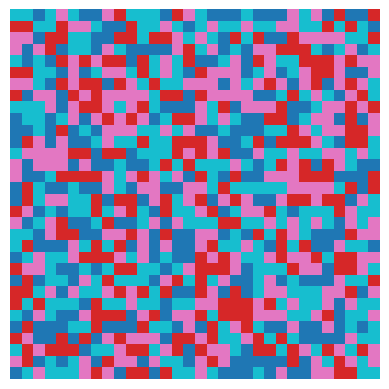

In [ ]:
# generate a 32x32 pixel image of four colour noise
import matplotlib.pyplot as plt
import numpy as np

img_size = 32
num_colors = 4
image = np.random.randint(0, num_colors, size=(img_size, img_size))
plt.imshow(image, cmap='tab10', vmin=0, vmax=num_colors-1)
plt.axis('off')
plt.show()
